In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from seminartools.models.utils import get_mse_by_country
from seminartools.data import read_merged
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel

# 1. Read data

In [3]:
df = read_merged().reset_index()
df

,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [4]:
# expanding window crossval
from seminartools.time_series_split import ExpandingWindowSplit

tss = ExpandingWindowSplit(start_date = "2000-01-01")
tss

# 2. Get stats (in percentage points)

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/hom

Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x7ffa43cb3790>)


100%|██████████| 20/20 [00:00<00:00, 1351.00it/s]


Fitted!
Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x7ff994a08590>)


100%|██████████| 20/20 [00:00<00:00, 3871.61it/s]


Fitted!


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


,4qa,pca_var,armax,uc_sv,uc_sv_ss,random_effects,distance
country,,,,,,,
Australia,0.004385,0.005404,0.004770,0.004002,0.004635,0.005419,0.005436
Belgium,0.004559,0.005096,0.005045,0.004902,0.004944,0.004432,0.004611
Canada,0.004738,0.005481,0.005805,0.004543,0.003490,0.008285,0.008499
Denmark,0.003323,0.003782,0.004666,0.003764,0.002429,0.003831,0.004006
France,0.002302,0.002069,0.002841,0.002553,0.001412,0.002748,0.002775
Germany,0.002819,0.005422,0.006151,0.003772,0.003191,0.004237,0.004231
Italy,0.003124,0.005419,0.004362,0.004107,0.004372,0.003831,0.003720
Japan,0.002451,0.004769,0.002879,0.002481,0.002852,0.003539,0.003519
Korea,0.003178,0.005027,0.003685,0.003422,0.002798,0.003813,0.003481


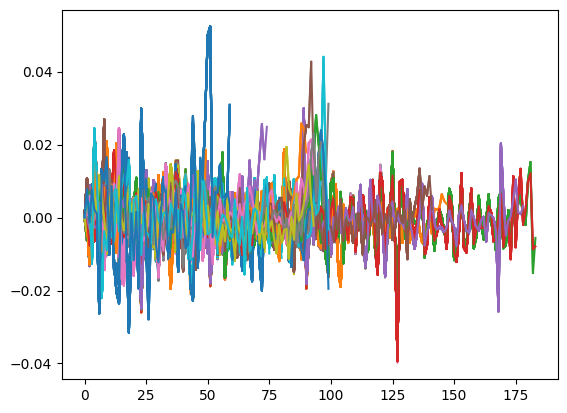

In [5]:
from seminartools.models.utils import get_mse_by_country

stats = get_mse_by_country(
    [
        ("4qa", lambda: FourQuarterAverageModel()),
        ("pca_var", lambda: PCAVARModel()),
        ("armax", lambda: ARMAXModel(max_p=2, max_q=0)),
       
       (
            "uc_sv",
           lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=False),
       ),
       (
           "uc_sv_ss",
           lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=True),
       ),
       ("random_effects", lambda: RandomEffectsModel()),
       ("distance", lambda: DistanceModel()),
        
    ],
    df,
    tss,
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats

# 3. Plot the Data

<Axes: xlabel='country'>

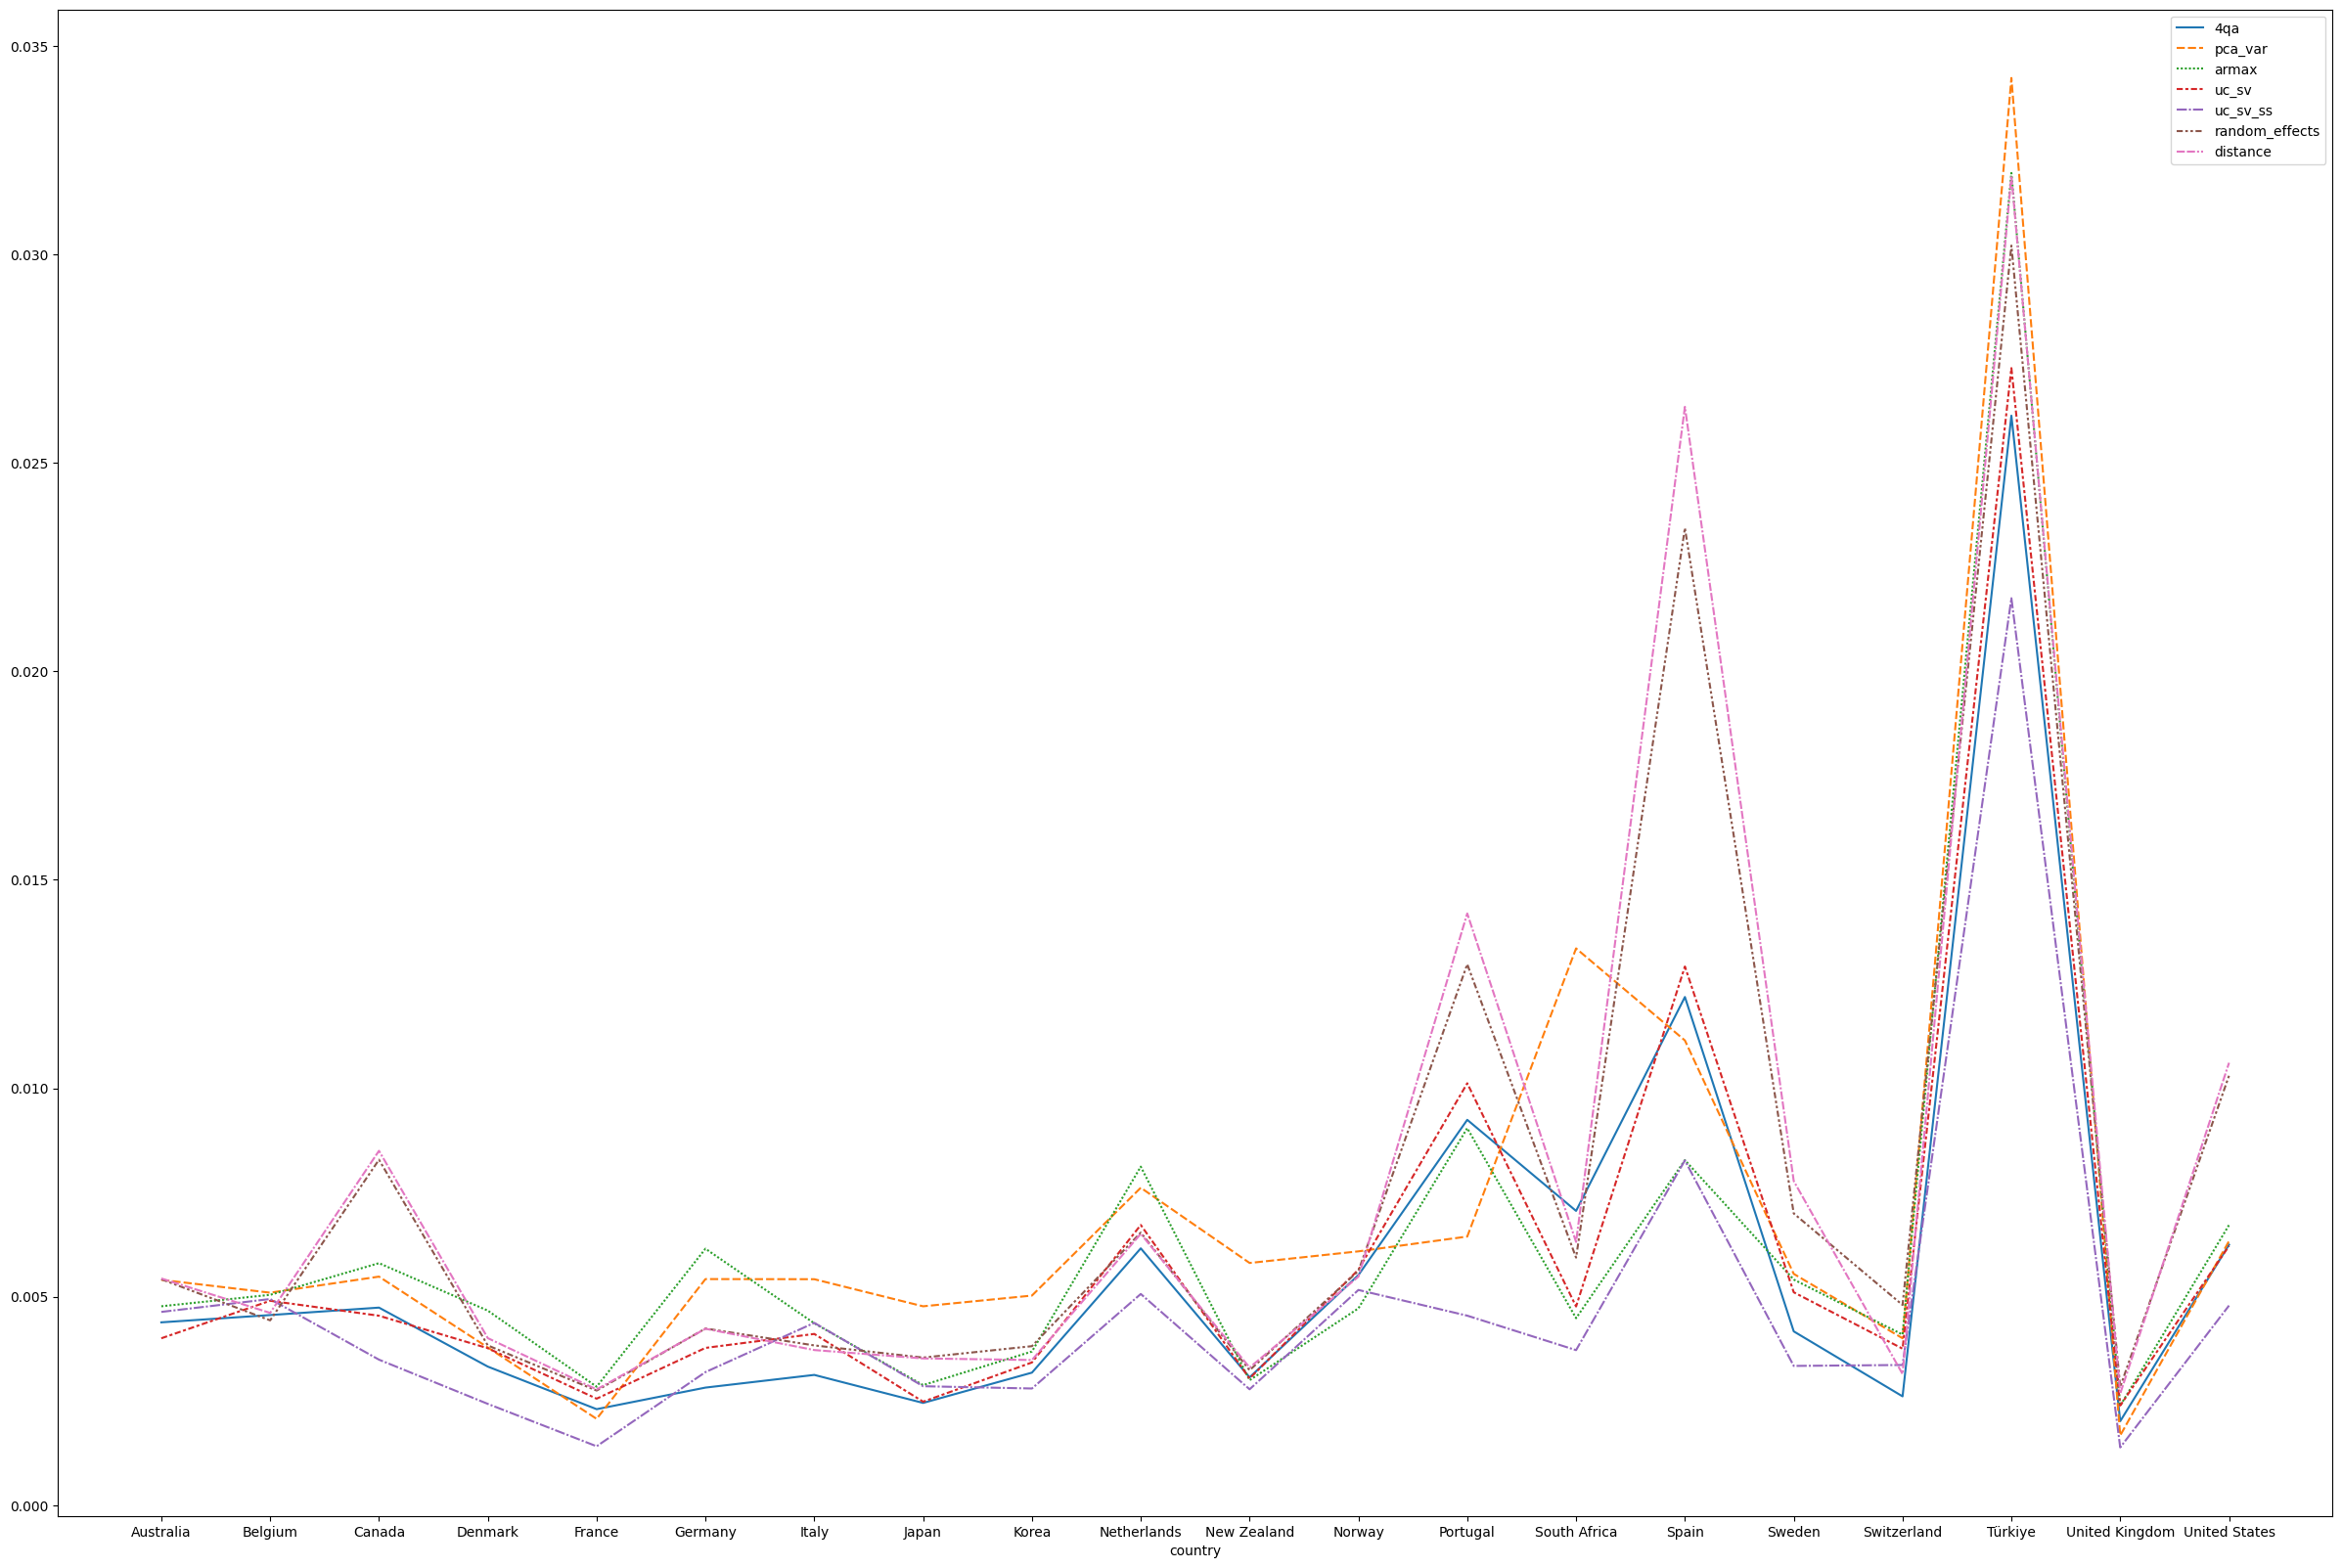

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
sns.lineplot(
    data = stats
)
